In [2]:
# Importing all the libraries
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from time import time


from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier




from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, SelectPercentile, f_classif, chi2
from sklearn.cross_validation import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score, log_loss, roc_auc_score, auc, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Set figure size
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4

To start the challenge, I read the dataset into a pandas dataframe, and took a glimpse of the dimensions of the dataset and the actual data.

In [4]:
# loading the data
data = pd.read_csv('data.csv')

print "The dimensions of the dataset are: {}\n".format(data.shape)
print data.head()

The dimensions of the dataset are: (20000, 303)

   id  train  target_eval  var_1  var_2  var_3  var_4  var_5  var_6  var_7  \
0   1      1            1  0.422  0.521  0.493  0.206  0.144  0.203  0.709   
1   2      1            0  0.345  0.974  0.330  0.643  0.931  0.664  0.146   
2   3      1            1  0.590  0.135  0.046  0.852  0.655  0.765  0.261   
3   4      1            1  0.226  0.952  0.773  0.070  0.800  0.320  0.081   
4   5      1            0  0.250  0.698  0.781  0.060  0.427  0.096  0.176   

    ...     var_291  var_292  var_293  var_294  var_295  var_296  var_297  \
0   ...       0.188    0.143    0.432    0.872    0.282    0.152    0.878   
1   ...       0.164    0.676    0.647    0.437    0.853    0.908    0.141   
2   ...       0.147    0.822    0.769    0.743    0.293    0.806    0.610   
3   ...       0.155    0.240    0.553    0.102    0.092    0.016    0.785   
4   ...       0.699    0.765    0.946    0.112    0.744    0.181    0.861   

   var_298  var_299

In the next step, I seperated the training and the testing dataset. Later fetched the features and labels from the training data to fit the model. Fetched the required columns to prepare the testing dataset for performing prediction on it.

In [6]:
# Seperating the training and testing data
data_train = data[data['train'] == 1]
data_test = data[data['train'] == 0]

# fetching the features and labels from training data
labels = data_train['target_eval']
features= data_train.drop(['id','train','target_eval'], axis=1)
# Preprocessing testing data set
TestIDs = data_test['id']
test = data_test.drop(['id','train','target_eval'], axis=1)

Before fitting the model, I used training testing split to split the 250 rows of the training dataset keeping the test size of 0.20.

In [7]:
# Performing training testing split in stratified fashion using labels
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.20,random_state=88,stratify=labels)

In the next step, I ran an initial check to compare the time taken and roc scores of different estimators.
Included different algorithms in this step from the simplest GaussianNB to ensemble methods like AdaBoost,
RandomForest, GradientBoosting etc. 

I also used LinearDiscriminantAnalysis algorithm as it performs both the dimensionality reduction and the classification of data.

Besides that, I also wanted to check the performance of logistic regression which is a widely used algorithm for binary classification tasks.

In [8]:
# Running an initial check to make a choice of the algorithm to work upon.

def choose_estimator(scoring='ROC'):
    estimators = ['GaussianNB',
                  'SVC',
                  'LinearSVC',
                  'DecisionTreeClassifier',
                  'AdaBoostClassifier',
                  'RandomForestClassifier',
                  'KNeighborsClassifier',
                  'SGDClassifier',
                  'GradientBoostingClassifier',
                  'LogisticRegression',
                  'LinearDiscriminantAnalysis',
                  'QuadraticDiscriminantAnalysis'
                  ]
    
    TimeNScore={} # Dictionary to store the training time and roc score
    for est in estimators:
        clf = eval(est + '()')
        start_time = time()
        clf.fit(X_train,y_train)
        end_time = time()
        try:
            roc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='macro')
        except:
            continue
        TimeNScore[est] = (str(end_time-start_time)+'secs', roc_score)
    return TimeNScore

output = choose_estimator()

# sorting the output by the roc scores i.e the second value in the tuple
sorted(output.items(), key = lambda tup: tup[1][1], reverse= True)


/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[('LinearDiscriminantAnalysis', ('0.0434939861298secs', 0.85096153846153844)),
 ('LogisticRegression', ('0.00649189949036secs', 0.76762820512820507)),
 ('GaussianNB', ('0.00541114807129secs', 0.76442307692307687)),
 ('KNeighborsClassifier', ('0.00418496131897secs', 0.74599358974358987)),
 ('GradientBoostingClassifier', ('0.512752771378secs', 0.64423076923076916)),
 ('AdaBoostClassifier', ('0.381009101868secs', 0.61057692307692313)),
 ('RandomForestClassifier', ('0.0355911254883secs', 0.52003205128205132)),
 ('QuadraticDiscriminantAnalysis', ('0.00810599327087secs', 0.4375)),
 ('DecisionTreeClassifier', ('0.0274131298065secs', 0.41826923076923084))]

Clearly, LinearDiscriminantAnalysis with ROC of 0.8509 is performing better than other models. And, the reason is that, LDA performs dimensionality reduction before classifying the data.

LDA uses supervised techniques to compute the directions (“linear discriminants”) that will represent the axes that maximize the separation between multiple classes. Hence, moving further I tuned the LDA model using GridSearchCV



In [418]:
# Choosing the estimator
clf = LinearDiscriminantAnalysis()

# make the pipeline
pipe = make_pipeline(clf)

# Parameters for model optimization
params = {
    'lineardiscriminantanalysis__solver': ['svd'],
    'lineardiscriminantanalysis__store_covariance': [False, True],
    'lineardiscriminantanalysis__tol': [0.000001, 0.00001], 
    'lineardiscriminantanalysis__n_components': [70,100],
          } 

# Implement GridSearch
classifier = GridSearchCV(pipe,
                   param_grid=params,
                   scoring='roc_auc',
                   n_jobs=-1,
                   verbose=1)


# fit the model
classifier.fit(X_train,y_train) 

# ROC score calculation
roc_score = roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1], average='macro')

print "The roc score for LinearDiscriminantAnalysis classifier is : {}\n".format(roc_score)
print "Best estimator is:\n{}".format(classifier.best_estimator_)


# Perform the predictions on test data set using fitted LDA model
prob_lda = classifier.predict_proba(test)[:,1]
# Convert the output np array to pd Series
prob_lda = pd.Series(prob_lda, index=np.arange(250, 20000))
# Combine with the original ID's
submission_lda = pd.concat([TestIDs, prob_lda], axis=1)
# Write to csv file
##submission_lda.to_csv('summission.csv', sep=',', header=('Id','Predicted_Probability'), index=False)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
The roc score for LinearDiscriminantAnalysis classifier is : 0.850961538462

Best estimator is:
Pipeline(steps=[('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=70, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=1e-06))])


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.4s finished


In [425]:
submission_lda.columns = ['Id','Predicted_Probability']
print submission_lda

          Id  Predicted_Probability
250      251           6.469668e-01
251      252           8.601147e-01
252      253           9.941716e-01
253      254           9.993422e-01
254      255           9.952444e-01
255      256           7.619077e-01
256      257           6.169053e-01
257      258           3.999884e-01
258      259           2.325321e-01
259      260           8.244817e-01
260      261           9.964060e-01
261      262           9.999997e-01
262      263           7.212387e-01
263      264           9.999810e-01
264      265           7.591927e-05
265      266           9.774151e-01
266      267           4.200942e-05
267      268           9.999995e-01
268      269           2.240550e-01
269      270           3.127423e-01
270      271           1.523804e-01
271      272           3.066974e-07
272      273           6.308438e-02
273      274           8.519651e-01
274      275           6.728396e-01
275      276           2.498008e-01
276      277           8.616

The best ROC score that I have achieved even after tuning the LDA model was 0.8509. In the initial check for different algorithms, logistic regression came after lineardiscriminantanalysis in terms of ROC score.

It is known that traditional tools like logistic regression do not perform very well in the scenarios where the number of variables is more than the number of observations.

And given that PCA is a linear transformation technique used for dimensionality reduction like LDA, I fitted a logistic regression model in combination with Principal Component Analysis in the next step.

But, before fitting a logistic regression, it was appropriate to find the best principal components. 
PCA uses unsupervised techniques to find out the principal components that maximize the variance in the dataset.


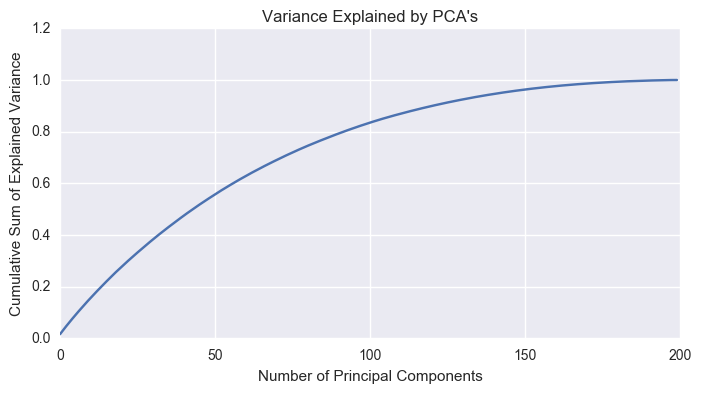

In [11]:
# Steps to find the optimal number of principal components.
# Scaling the data using standard scaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fitting the pca
pca = PCA()
pca.fit(X_train_scaled)
exp_ratio = pca.explained_variance_ratio_

pcomp = np.arange(X_train_scaled.shape[0]) # using the number of rows as no. of principal components

# plot the data
plt.plot(pcomp, np.cumsum(exp_ratio))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Sum of Explained Variance")
plt.title("Variance Explained by PCA's")

The above graph clearly shows steep increase in the explained variance until 150 PCA's. After that point we start to see saturation in this increment. 

After getting the notion about the no. of principal components to play with, I fitted a logistic regression after reducing the dimensions to 168 principal components. 

In [16]:
#Fitting a logistic regression in combination with PCA (playing with n_components parameter)

# pca = decomposition.PCA(n_components=160)
# pca = decomposition.PCA(n_components=165)
# pca = decomposition.PCA(n_components=170)

pca = PCA(n_components=168)
logistic = LogisticRegression()

logistic_pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
logistic_pipe.fit(X_train,y_train)



Pipeline(steps=[('pca', PCA(copy=True, n_components=168, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
pred = logistic_pipe.predict_proba(X_test)[:,1]
score=roc_auc_score(y_test,pred, average='macro')
print "The roc score for Logistic Regression is : {}\n".format(score)

The roc score for Logistic Regression is : 0.858974358974



The best ROC Score (0.8589) that I got from logistic regression was with 168 Principal Components. This value was a little better than the model using LDA for dimensionality reduction. Hence, I am used logistic regression in combination with PCA model to perform probability predictions on testing dataset.

In [18]:
# Performing the predictions on test data set using PCA & Logistic Regression
prob_logistic = logistic_pipe.predict_proba(test)[:,1]
# Converting the output probabilities from array to series
prob_logistic = pd.Series(prob_logistic, index=np.arange(250, 20000))
# Combining with the original ID's
submission_logistic = pd.concat([TestIDs, prob_logistic], axis=1)
# Writing to a csv file
submission_logistic.to_csv('summission_logistic.csv', sep=',', header=('Id','Predicted_Probability'), index=False)

In [19]:
submission_logistic.columns = ['Id','Predicted_Probability']
print submission_logistic

          Id  Predicted_Probability
250      251               0.813075
251      252               0.673837
252      253               0.875343
253      254               0.950983
254      255               0.796062
255      256               0.406442
256      257               0.196096
257      258               0.591553
258      259               0.961254
259      260               0.009411
260      261               0.919269
261      262               0.983925
262      263               0.507114
263      264               0.769259
264      265               0.056260
265      266               0.455880
266      267               0.472422
267      268               0.877461
268      269               0.098185
269      270               0.859440
270      271               0.312292
271      272               0.534464
272      273               0.397870
273      274               0.298579
274      275               0.218180
275      276               0.106046
276      277               0